# RAG Based on HyDE
- Hybrid Search
- ReRanker
- HyDE (Hypothetical Document Embeddings)

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Bedrock Client 생성

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models())

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3 모델 로딩

### LLM 로딩 (Claude-v3)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
    },
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7ff793e950f0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7ff7cb849810>])

### Embedding 모델 선택

In [7]:
from utils.rag import KoSimCSERobertaContentHandler, SagemakerEndpointEmbeddingsJumpStart

본 과정의 교육목표는 다음과 같습니다.

1. 프로그래밍 기초 지식 함양: 프로그래밍 언어의 기본 문법과 개념을 익혀 코딩 능력을 기릅니다.

2. 문제해결 능력 향상: 다양한 알고리즘 문제를 해결하며 논리적 사고력과 문제해결 능력을 키웁니다. 

3. 프로젝트 수행 경험: 팀 프로젝트를 통해 실무 개발 환경을 경험하고 협업 능력을 기릅니다.

4. 컴퓨터 사고력 배양: 컴퓨터의 작동 원리를 이해하고 프로그래밍 방식으로 사고하는 능력을 갖춥니다.

5. 지속적인 자기계발: 빠르게 변화하는 기술 동향을 따라가며 평생 학습 태도를 기릅니다.본 과정의 교육목표는 다음과 같습니다:

1. 학생들에게 기초적인 지식과 기술을 가르쳐 전문성을 갖추도록 한다.
2. 창의력과 문제해결능력을 기를 수 있는 다양한 프로젝트를 수행한다. 
3. 협동심과 리더십을 함양하여 팀워크 능력을 배양한다.
4. 직업윤리와 사회적 책임의식을 고취시켜 바람직한 인성을 기른다.
5. 졸업 후 관련 분야에서 전문가로 활동할 수 있는 기반을 마련한다.본 강좌의 교육목표는 다음과 같습니다:

1. 학생들에게 기본적인 프로그래밍 개념과 원리를 전달합니다.
2. 문제해결능력과 논리적 사고력을 기릅니다.
3. 프로그래밍 언어와 개발 도구 사용법을 익힙니다.
4. 팀 프로젝트를 통해 협업 능력과 의사소통 능력을 향상시킵니다.
5. 컴퓨터 분야에 대한 관심과 열정을 고취시킵니다.

이 강좌를 통해 학생들은 프로그래밍 기초 지식을 쌓고 실무에 필요한 기술을 습득할 수 있을 것입니다.본 대학의 교육목표는 다음과 같습니다:

1. 전인적 인격을 갖춘 민주시민 양성
2. 창의적 전문인 육성
3. 봉사정신을 실천하는 지도자 배출
4. 세계화와 정보화 시대를 선도할 인재 양성

우리 대학은 이러한 목표 아래 이론과 실무를 겸비한 유능한 인재를 길러내어 국가와 인류사회 발전에 이바지하고자 합니다.이 학교의 교육 목표는 학생들에게 전인적인 성장을 도모하는 것입니다. 지적, 정서적, 신체적 발달을 균형있게 이루어 미래 사회에서

In [8]:
def get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name=None):
    
    if is_bedrock_embeddings:
        # We will be using the Titan Embeddings Model to generate our Embeddings.
        from langchain.embeddings import BedrockEmbeddings
        llm_emb = BedrockEmbeddings(
            client=boto3_bedrock,
            model_id=bedrock_info.get_model_id(
                model_name="Titan-Embeddings-G1"
            )
        )
        print("Bedrock Embeddings Model Loaded")

    elif is_KoSimCSERobert:
        LLMEmbHandler = KoSimCSERobertaContentHandler()
        endpoint_name_emb = endpont_name
        llm_emb = SagemakerEndpointEmbeddingsJumpStart(
            endpoint_name=endpoint_name_emb,
            region_name=aws_region,
            content_handler=LLMEmbHandler,
        )        
        print("KoSimCSERobert Embeddings Model Loaded")
    else:
        llm_emb = None
        print("No Embedding Model Selected")
    
    return llm_emb

#### [중요] is_KoSimCSERobert == True 일시에 endpoint_name 을 꼭 넣어 주세요.

In [9]:
is_bedrock_embeddings = True
is_KoSimCSERobert = False
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

##############################
# Parameters for is_KoSimCSERobert
##############################
if is_KoSimCSERobert: endpont_name = "<endpoint-name>"
else: endpont_name = None
##############################

llm_emb = get_embedding_model(is_bedrock_embeddings, is_KoSimCSERobert, aws_region, endpont_name)   

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [10]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [11]:
depoly = False

In [12]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [13]:
import boto3
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [ ]:
pm.put_params(
    key="reranker_endpoint",
    value=f'{predictor.endpoint}',
    overwrite=True,
    enc=False
)

## 4. Invocation (prediction)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7ff718b3f2b0>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9987371563911438}, {'label': 'LABEL_0', 'score': 0.0028581616934388876}]
CPU times: user 14.4 ms, sys: 222 µs, total: 14.6 ms
Wall time: 91 ms


## 5. LangChainmOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [19]:
import boto3
from utils.ssm import parameter_store

In [20]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [21]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [22]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [23]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index


### OpenSearch Client 생성

In [24]:
from utils.opensearch import opensearch_utils

In [25]:
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 6. Retriever based on Hybrid Search + HyDE + ReRanker
- LangChain에서 제공하는 **BaseRetriever** 클래스를 상속받아 **Custom Retriever**를 정의 할 수 있습니다.
- Hybrid-Search에 대한 자세한 내용는 **"01_rag_hybrid_search.ipyno"** 에서 확인 가능합니다.
- [HyDE](https://medium.com/prompt-engineering/hyde-revolutionising-search-with-hypothetical-document-embeddings-3474df795af8)
![HyDE.png](../../../imgs/HyDE.png)

In [26]:
from utils.rag import OpenSearchHybridSearchRetriever

- 필터 설정 예시
- filter=[ <BR>
    　{"term": {"metadata.[**your_metadata_attribute_name**]": "**your first keyword**"}}, <BR>
    　{"term": {"metadata.[**your_metadata_attribute_name**]": "**your second keyword**"}},<BR>
]

In [31]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb,

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for lexical, for semantic], Lexical, Semantic search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    hyde=True, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    

    # option for async search
    async_mode=False,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True,
)

### Retrieval example
- default search

In [32]:
from utils.rag import show_context_used

In [33]:
query = "중지된 경우 이체"

In [34]:
%%time
search_hybrid_result = opensearch_hybrid_retriever.get_relevant_documents(query)

print("\n==========  Results  ==========\n")
print(f'1. question: {query}')
print (f'2. # documents: {len(search_hybrid_result)}')
print("3. Documents: \n")

show_context_used(search_hybrid_result)



===== HyDE Answers =====
['교육목표는?', '본 과정의 교육목표는 다음과 같습니다:\n\n1. 학생들에게 기초적인 지식과 기술을 가르쳐 전문성을 갖추도록 한다.\n2. 창의력과 문제해결능력을 기를 수 있는 다양한 프로젝트를 수행한다. \n3. 협동심과 리더십을 함양하여 팀워크 능력을 배양한다.\n4. 직업윤리와 사회적 책임의식을 고취시켜 바람직한 인성을 기른다.\n5. 졸업 후 관련 분야에서 전문가로 활동할 수 있는 기반을 마련한다.']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
False
##############################
HyDE
##############################
True
##############################
parent_document
##############################
False
##############################
complex_document
##############################
False
#####################

- update parameters

In [35]:
opensearch_hybrid_retriever.update_search_params(
    k=5,
    minimum_should_match=30,
    filter=[
        #{"term": {"metadata.project": "KS"}},
    ],
    reranker=True,
    reranker_endpoint_name=endpoint_name,
    hyde=True, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    verbose=True
)

In [36]:
query = "중지된 경우 이체"
search_hybrid_result = opensearch_hybrid_retriever.get_relevant_documents(query)

print("\n==========  Results  ==========\n")
print(f'1. question: {query}')
print(f'2. # documents: {len(search_hybrid_result)}')
print("3. Documents: \n")

show_context_used(search_hybrid_result)



===== HyDE Answers =====
['교육목표는?', '본 강좌의 교육목표는 다음과 같습니다:\n\n1. 학생들에게 기본적인 프로그래밍 개념과 원리를 전달합니다.\n2. 문제해결능력과 논리적 사고력을 기릅니다.\n3. 프로그래밍 언어와 개발 도구 사용법을 익힙니다.\n4. 팀 프로젝트를 통해 협업 능력과 의사소통 능력을 향상시킵니다.\n5. 컴퓨터 분야에 대한 관심과 열정을 고취시킵니다.\n\n이 강좌를 통해 학생들은 프로그래밍 기초 지식을 쌓고 실무에 필요한 기술을 습득할 수 있을 것입니다.']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 1


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
False
##############################
HyDE
##############################
True
##############################
parent_document
##############################
False
##############################
complex_document
##############################

## 5. RAG using RetrievalQA powered by LangChain

In [37]:
from utils.rag import prompt_repo

### Prompting
- [TIP] Prompt의 instruction의 경우 한글보다 영어로 했을 때 더 좋은 결과를 얻을 수 있습니다.

In [38]:
system_prompt = prompt_repo.get_system_prompt()
pprint (system_prompt)

('\n'
 '                        You are a master answer bot designed to answer '
 "user's questions.\n"
 "                        I'm going to give you contexts which consist of "
 'texts, tables and images.\n'
 "                        Read the contexts carefully, because I'm going to "
 'ask you a question about it.\n'
 '                        ')


### Update Search Params (Optional)

In [39]:
from utils.rag import qa_chain
from langchain.schema.output_parser import StrOutputParser

In [65]:
opensearch_hybrid_retriever.update_search_params(
    k=10,
    minimum_should_match=0,
    filter=[],
    reranker=True,
    reranker_endpoint_name=endpoint_name,
    hyde=False, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    llm_text=llm_text, # llm for query augmentation in rag_fusion
    async_mode=True,
    verbose=False,
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다.
)

### Request

In [66]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

초등학교 교육 과정은 다음과 같은 내용을 포함하고 있습니다.

1. 문화예술교육 강화: 예술강사 무용 수업, 1인 1악기(칼림바), 문화예술교실, 상록 문화예술의 날 행사 등을 통해 예술교육을 강화함.

2. 스포츠클럽 활성화: 반별 스포츠클럽 조직 및 운영, 스포츠클럽데이 행사 등을 통해 체육활동을 장려함.  

3. 건강체력증진 프로그램: 줄넘기 급수제, 건강체력교실, 생존수영교육, 해양안전체험활동 등을 운영하여 학생들의 건강과 체력 향상을 도모함.

4. 놀이중심 교육과정 운영: 놀이교실 확보, 블록타임 놀이시간 확보, 점심시간 자유놀이 시간 확보 등을 통해 학생들에게 휴식과 놀이 기회를 제공함.

5. 생태환경교육: 숲체험교실, 탄소중립환경교육, 교과연계환경교육, 환경교육주간 운영 등을 통해 학생들의 환경의식을 기름.

6. 인성교육: 인성교육실천주간, 학급별 인성교육, 친구사랑의 날 행사, 예절교실 운영 등을 통해 학생들의 인성을 함양함.
-----------------------------------------------
1. Category: CompositeElement, Chunk: 699 Characters
-----------------------------------------------
‧ 창의적 체험활동의 영역별 활동내용, 평가방법 및 기준은 교육과정을 근 - 9 - □5 선행교육 예방 (공교육정상화법) 교사 우○주 ❍ 선행교육 -「초‧중등교육법」제23조제2항에
따라 교육부장관이 정한 초․중등학교 교육과정(국가교육과정) 및 교육감이 정한 초․중등학교 교육과정(시․도교육과정), 「초‧중등교육법」제23조제1항에 근거하여 편성․운영되는 단위학교
교육과정(학교 교육과정) 국가교육과정-시․도교육과정-학교 교육과정에 앞서서 편성 또는 제공하는 교육 일반 ❍ 선행학습 - 학습자가 국가교육과정, 시․도교육과정, 학교 교육과정에
앞서서 하는 학습 1. 추진 근거 및 목적 L RIS 가. 근거 Ÿ 「공교육 정상화 촉진 및 선행교육 규제에 관한 특별법」(

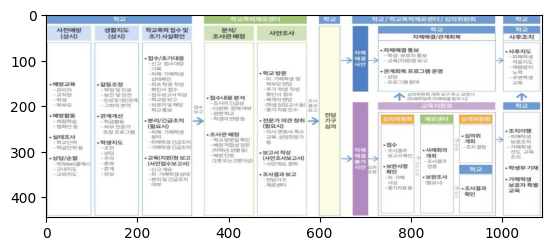

이 이미지는 학교 활동의 전반적인 과정을 설명하는 흐름도입니다. 왼쪽에서 시작하여 학교, 학교운영계획, 사업운영 등의 준비 단계를 거쳐 중앙의 학부모회, 사인회 등 학교 운영
주체들이 관여하는 활동 과정을 보여줍니다. 마지막으로 학교 활동의 결과로 학교평가, 자체평가, 재정지원 등의 결과물이 산출되는 것을 나타내고 있습니다. 전체적으로 학교 운영의 전체
흐름을 구조화하여 제시하고 있습니다.
metadata:
 {'img_path': './fig/figure-37-88-resize.jpg', 'category': 'Image', 'image_base64': '',
'family_tree': 'parent_image', 'parent_id': 'NA', 'id': '8f3a8a9d-d8bf-44e9-a61f-ea51c75f2553',
'origin_image': ''}

-----------------------------------------------
3. Category: Table, Chunk: 531 Characters
-----------------------------------------------
이 표는 학교에서 운영하는 다양한 교육활동을 정리한 것입니다. 주요 내용은 다음과 같습니다.

1. 문화예술교육의 강화: 아르떼 예술강사 무용 수업, 1인 1악기(칼림바), 문화예술교실(악기교실), 상록 문화예술의 날 행사 등을 통해 예술교육을 강화함.

2. 학교 스포츠클럽 활성화: 반별 스포츠 클럽 조직 및 운영, 스포츠클럽데이 운영 등을 통해 학생들의 체육활동을 장려함.

3. 건강, 체력 증진 프로그램: 줄넘기 급수제, 건강체력교실, 생존수영교육, 해양 안전 체험활동 등을 운영하여 학생들의 건강과 체력 향상을 도모함.

4. 놀이와 쉼이 있는 교육과정 운영: 학년별 놀이교실 확보, 블록타임 놀이시간 확보, 점심시간 자유놀이 시간 확보 등을 통해 학생들에게 휴식과 놀이 기회를 제공함.

5. 체험중심의 생태환경교육: 숲체험교실, 탄소중립 환경교육, 

In [67]:
query = "중지된 경우 이체"
query = "초등학교 교육 과정"
#query = "vidio max size?"

response, contexts = qa.invoke(
    query = query
)

show_context_used(contexts)

##################################
query:  초등학교 교육 과정
##################################


### Answer ###
초등학교 교육 과정은 다음과 같은 내용을 포함하고 있습니다.

1. 문화예술교육 강화: 예술강사 무용 수업, 1인 1악기(칼림바), 문화예술교실, 상록 문화예술의 날 행사 등을 통해 예술교육을 강화함.

2. 스포츠클럽 활성화: 반별 스포츠클럽 조직 및 운영, 스포츠클럽데이 행사 등을 통해 체육활동을 장려함.

3. 건강체력증진 프로그램: 줄넘기 급수제, 건강체력교실, 생존수영교육, 해양안전체험활동 등을 운영하여 학생들의 건강과 체력 향상을 도모함.

4. 놀이중심 교육과정 운영: 놀이교실 확보, 블록타임 놀이시간 확보, 점심시간 자유놀이 시간 확보 등을 통해 학생들에게 휴식과 놀이 기회를 제공함.

5. 생태환경교육: 숲체험교실, 탄소중립환경교육, 교과연계환경교육, 환경교육주간 운영 등을 통해 학생들의 환경의식을 기름.

6. 인성교육: 인성교육실천주간, 학급별 인성교육, 친구사랑의 날 행사, 예절교실 운영 등을 통해 학생들의 인성을 함양함.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 699 Characters
-----------------------------------------------
‧ 창의적 체험활동의 영역별 활동내용, 평가방법 및 기준은 교육과정을 근 - 9 - □5 선행교육 예방 (공교육정상화법) 교사 우○주 ❍ 선행교육 -「초‧중등교육법」제23조제2항에
따라 교육부장관이 정한 초․중등학교 교육과정(국가교육과정) 및 교육감이 정한 초․중등학교 교육과정(시․도교육과정), 「초‧중등교육법」제23조제1항에 근거하여 편성․운영되는 단위학교
교육과정(학교 교육과정) 국가교육과정-시․도교육과정-학교 교육과정에 앞서서 편성

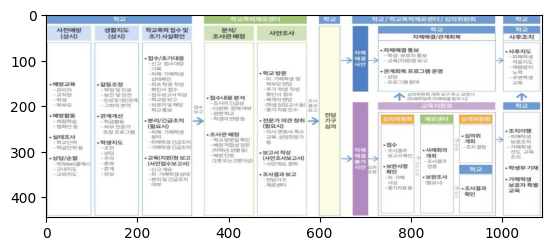

이 이미지는 학교 활동의 전반적인 과정을 설명하는 흐름도입니다. 왼쪽에서 시작하여 학교, 학교운영계획, 사업운영 등의 준비 단계를 거쳐 중앙의 학부모회, 사인회 등 학교 운영
주체들이 관여하는 활동 과정을 보여줍니다. 마지막으로 학교 활동의 결과로 학교평가, 자체평가, 재정지원 등의 결과물이 산출되는 것을 나타내고 있습니다. 전체적으로 학교 운영의 전체
흐름을 구조화하여 제시하고 있습니다.
metadata:
 {'img_path': './fig/figure-37-88-resize.jpg', 'category': 'Image', 'image_base64': '',
'family_tree': 'parent_image', 'parent_id': 'NA', 'id': '8f3a8a9d-d8bf-44e9-a61f-ea51c75f2553',
'origin_image': ''}

-----------------------------------------------
3. Category: Table, Chunk: 531 Characters
-----------------------------------------------
이 표는 학교에서 운영하는 다양한 교육활동을 정리한 것입니다. 주요 내용은 다음과 같습니다.

1. 문화예술교육의 강화: 아르떼 예술강사 무용 수업, 1인 1악기(칼림바), 문화예술교실(악기교실), 상록 문화예술의 날 행사 등을 통해 예술교육을 강화함.

2. 학교 스포츠클럽 활성화: 반별 스포츠 클럽 조직 및 운영, 스포츠클럽데이 운영 등을 통해 학생들의 체육활동을 장려함.

3. 건강, 체력 증진 프로그램: 줄넘기 급수제, 건강체력교실, 생존수영교육, 해양 안전 체험활동 등을 운영하여 학생들의 건강과 체력 향상을 도모함.

4. 놀이와 쉼이 있는 교육과정 운영: 학년별 놀이교실 확보, 블록타임 놀이시간 확보, 점심시간 자유놀이 시간 확보 등을 통해 학생들에게 휴식과 놀이 기회를 제공함.

5. 체험중심의 생태환경교육: 숲체험교실, 탄소중립 환경교육, 

In [69]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)

print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts)